Investigating the Source of a Target OSETI Signal via Doppler Shift
---------------------------

Benji sent me three HARPS observations to investigate.  One is a SETI candidate his algorithm identified, the other two are observations taken near the same time of other stars.  Can we identify the source of the candidate emission line?

    Star: HD126535,  Observation (Raw CCD Image): HARPS.2013-06-01T03:58:57.602.fits
                Observation (Reduced 1-D Spectrum): ADP.2014-10-06T10_04_46.673.fits
                Wavelength: 5732.85 Angstroms
    
    Star: HD127423, Observation (Raw CCD Image): HARPS.2013-06-01T04:16:19.375.fits
                Observation (Reduced 1-D Spectrum): ADP.2014-10-06T10_06_38.740.fits
                Wavelength: 5732.93 Angstroms
    
    Star HD143120, Observation (Raw CCD Image): HARPS.2013-06-01T04:33:53.818.fits
                Observation (Reduced 1-D Spectrum): ADP.2014-10-06T10_04_27.593.fits
                Wavelength: 5733.1 Angstroms

New harpscompare.py
---------------------------
This notebook uses a new version of harpscompare.py that automatically registers the wavelengths in the spectral and ccd image plots as closely as possible.  It also allows you to separately set y-scale for spectral grap and color scale for the CCD plot.

    compare_spec_to_raw(specfilename,rawfilename,lamb,spec_countmin=-1,spec_countmax=-1,raw_countmin=-1,raw_countmax=-1,order_shift=0):
        Plot spectrum and CCD image file on the same figure.  
        Plots one full spectral order containing a given wavelength.
        * specfilename: file name of downloaded HARPS spectrum file
        * rawfilename: file name of downloaded raw CCD image
        * lamb: target wavelength, in *nanometers*
        * spec_countmin, spec_countmax: minimum and maximum range of spectral plot.  
         Optional: if left blank or set to -1, "reasonable" values will be autoselected.
        * raw_countmin, raw_countmax: minimum and maximum range of ccd image.  
          Optional: if left blank or set to -1, will use the same range as spec_countmin, spec_countmax above.


Matplotlib magic

In [1]:
%matplotlib widget


Set up and import

In [2]:
from astroquery.eso import Eso
eso = Eso()
from pathlib import Path
eso_cache_folder = Path(eso.cache_location)
import harpscompare
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np


In [3]:
if not eso.authenticated():
    eso.login(username="goodmanj", store_password=True)

INFO: Authenticating goodmanj on www.eso.org... [astroquery.eso.core]
INFO: Authentication successful! [astroquery.eso.core]


Define spectral data files, ccd data files, and target wavelengths.  Check to make sure all files are downloaded.

In [4]:
specfiles = ["ADP.2014-10-06T10_04_46.673.fits","ADP.2014-10-06T10_06_38.740.fits","ADP.2014-10-06T10_04_27.593.fits"]
rawfiles = ["HARPS.2013-06-01T03_58_57.602.fits","HARPS.2013-06-01T04_16_19.375.fits","HARPS.2013-06-01T04_33_53.818.fits"]
lambs = [5732.85,5732.93,5733.1]
rawfiles = [eso_cache_folder/file for file in rawfiles]
specfiles = [eso_cache_folder/file for file in specfiles]
print(rawfiles)
print(specfiles)
print([file.exists() for file in specfiles])
print([file.exists() for file in rawfiles])

[WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/HARPS.2013-06-01T03_58_57.602.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/HARPS.2013-06-01T04_16_19.375.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/HARPS.2013-06-01T04_33_53.818.fits')]
[WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-10-06T10_04_46.673.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-10-06T10_06_38.740.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-10-06T10_04_27.593.fits')]
[True, True, True]
[True, True, True]


Download data files. Skip if already downloaded.

In [5]:
for i in range(len(specfiles)):
    if not specfiles[i].exists():
        print(specfiles[i].stem)
        harpscompare.download_spectrum(specfiles[i].stem)
    if not rawfiles[i].exists():
        print(rawfiles[i].name)
        harpscompare.download_associated_raw(specfiles[i])


Superimposed Spectra using Radial Velocity Header Data
------------------------------------------------------
The header "HIERARCH ESO TEL TARG RADVEL" gives the predicted estimate for the radial velocity of the star relative to the reference frame the spectra are reported in, which I *think* is the barycentric frame.

https://openaccess.inaf.it/bitstream/20.500.12386/31285/4/TNG-MAN-HARPN-0005_HARPS-N_DRS_Manual_i1r2.pdf



In [6]:
radvel = []
for f in specfiles:
    fitsfile = fits.open(f)
    print(fitsfile[0].header["HIERARCH ESO TEL TARG RADVEL"])

-19.9
-29.8
-23.6


Define doppler shift function

In [7]:
def doppler(wave,v):
    c = 2.998e5 # km/s
    beta = v/c
    return wave*np.sqrt((1-beta)/(1+beta))

Extract and plot spectra for all three obs.  Plot both spectrum file's "native" reference frame, and doppler-shifted spectra using `HIERARCH ESO TEL TARG RADVEL`.

In the files' default frame (first panel), neither the absorption lines nor the target emission lines line up, which is expected because we're not in the star's reference frame.

Second panel shows the same spectra, doppler-shifted using "HIERARCH ESO TEL TARG RADVEL".  The stellar absorption lines now stack up perfectly, as they should, but our emission feature does not.  Conclusion: the source of our emission is not stationary with respect to the target stars.

[0, 0, 0] [-19.9, -29.8, -23.6]


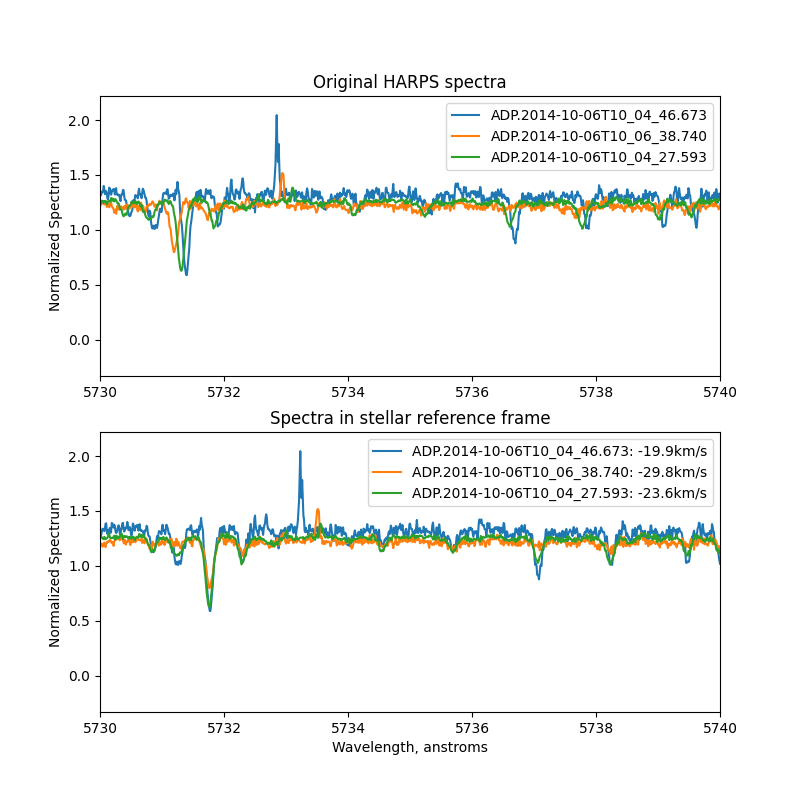

In [8]:

plt.figure(3)
plt.figure(3).set_size_inches(8,8)
plt.clf()
specfits = [fits.open(f) for f in specfiles]
radvels = [f[0].header["HIERARCH ESO TEL TARG RADVEL"] for f in specfits]
wave = [f[1].data[0][0] for f in specfits]
arr1 = [f[1].data[0][1] for f in specfits]
norm_spec = [s/np.median(s) for s in arr1]

wavelim = [5730,5740]
plt.subplot(2,1,1)
for i in range(len(specfiles)):
    plt.plot(wave[i],norm_spec[i])
plt.xlim(wavelim)
plt.legend([f.stem for f in specfiles])
plt.title("Original HARPS spectra")
plt.ylabel("Normalized Spectrum")
topax = plt.gca()
plt.subplot(2,1,2,sharex=topax,sharey=topax)
wave_star_frame = [0 for w in wave]
print(wave_star_frame,radvels)
for i in range(len(specfiles)):
    wave_star_frame[i] = doppler(wave[i],radvels[i])
    plt.plot(wave_star_frame[i],norm_spec[i])
plt.title("Spectra in stellar reference frame")
plt.legend([specfiles[i].stem + ": " + str(radvels[i]) + "km/s" for i in range(len(specfiles))])
plt.xlim(wavelim)
plt.xlabel("Wavelength, anstroms")
plt.ylabel("Normalized Spectrum")
plt.show()

Identifying Doppler Shift in Raw CCD Images
-------------------------------------------
But what reference frame *are* the emission features in?  I don't have data on Earth's barycentric velocity without doing a lot of math.  Instead, I thought to compare the emission lines against the thorium calibration lamp in the raw CCD images.  Let's use `harpscompare` to look at them:

Reload harpscompare module for debugging purposes, Then run harpscompare on the first file.

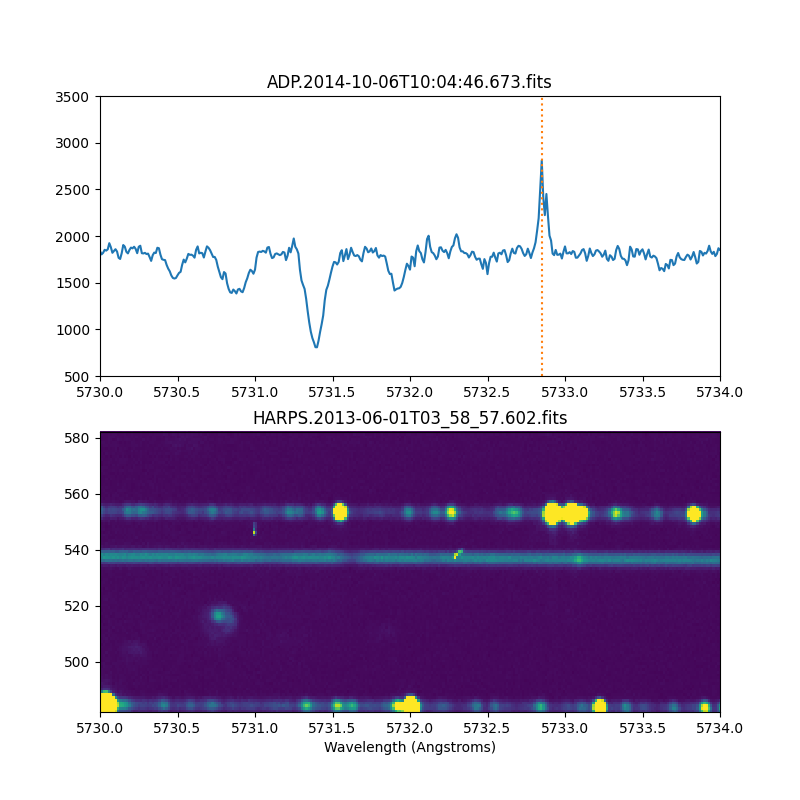

In [9]:
import importlib
importlib.reload(harpscompare)
plt.ion()
plt.figure(0)
plt.figure(0).set_size_inches(8,8)
fig0 = plt.gcf()
plt.clf()

#lamb_range = [573,574]
lamb_range = [573,573.4]

harpscompare.compare_spec_to_raw(specfiles[0],rawfilename=rawfiles[0],lamb=lambs[0]/10,lamb_range=lamb_range,
                                 spec_countmin=500,spec_countmax=3500,raw_countmin=00,raw_countmax=1000)
plt.plot([5731.55,5731.55],[560,570],'r')
plt.plot([5731.62,5731.62],[520,530],'r')
plt.plot([5733.04,5733.04],[560,570],'r')
plt.plot([5733.09,5733.09],[520,530],'r')

Note that the absorption feature at 5731.5 angstroms is just to the right of the calibration line above it, and the mystery emission feature at 5733 angstroms is almost even with the calibration line above it.

repeat for the second and third files

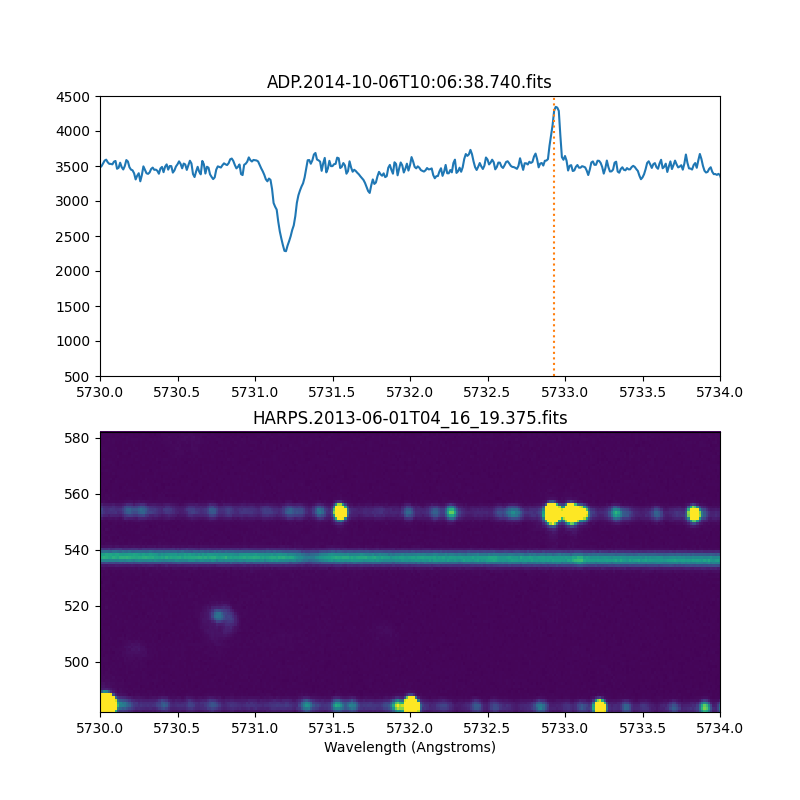

In [10]:
plt.figure(1)
plt.figure(1).set_size_inches(fig0.get_size_inches())
plt.clf()


#lamb_range = [573,574]
lamb_range = [573,573.4]

harpscompare.compare_spec_to_raw(specfiles[1],rawfilename=rawfiles[1],lamb=lambs[1]/10,lamb_range=lamb_range,
                                 spec_countmin=500,spec_countmax=4500,raw_countmin=00,raw_countmax=1500)
plt.plot([5731.55,5731.55],[560,570],'r')
plt.plot([5731.35,5731.35],[520,530],'r')
plt.plot([5733.04,5733.04],[560,570],'r')
plt.plot([5733.09,5733.09],[520,530],'r')

Here, the absorption feature at 5731.5 angstroms is doppler-shifted to the *left* of the  calibration  line above it, but the mystery emission feature at 5733 angstroms is still almost even with the  calibration  line above it.

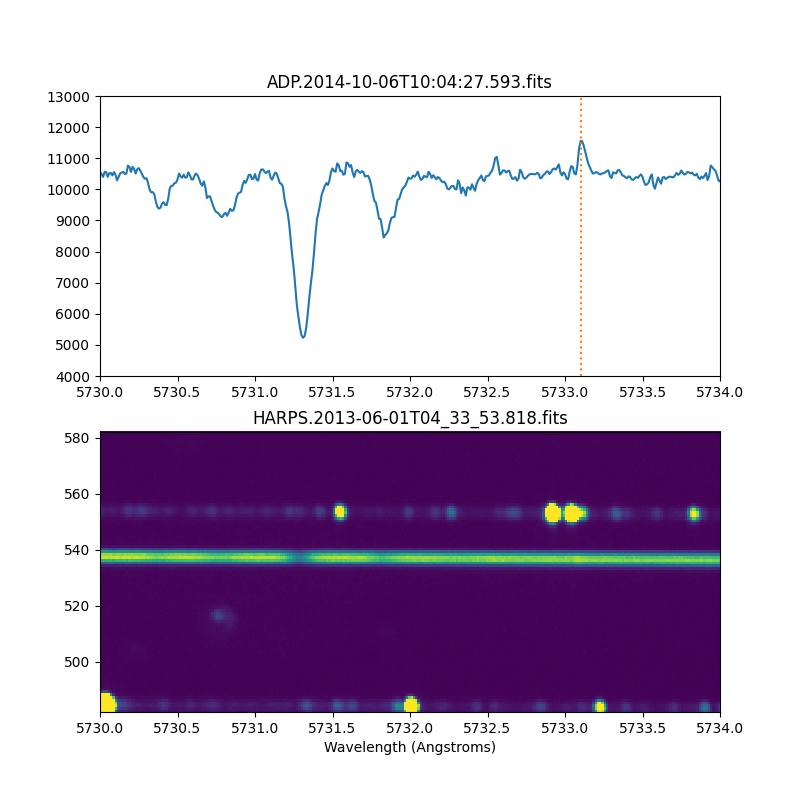

In [11]:
plt.figure(2)
plt.figure(2).set_size_inches(fig0.get_size_inches())
plt.clf()

#lamb_range = [573,574]
lamb_range = [573,573.4]

harpscompare.compare_spec_to_raw(specfiles[2],rawfilename=rawfiles[2],lamb=lambs[2]/10,lamb_range=lamb_range,
                                 spec_countmin=4000,spec_countmax=13000,raw_countmin=00,raw_countmax=3000)
plt.plot([5731.55,5731.55],[560,570],'r')
plt.plot([5731.28,5731.28],[520,530],'r')
plt.plot([5733.04,5733.04],[560,570],'r')
plt.plot([5733.09,5733.09],[520,530],'r')

Once again, the absorption feature at 5731.5 angstroms is doppler-shifted to the *left* of the  calibration  line above it, but the mystery emission feature at 5733 angstroms is still almost even with the  calibration  line above it.

Conclusion: this mystery emission line is **stationary with respect to the telescope, not the star**.  Whatever it is, it's terrestrial.
